In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import matplotlib as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

from keras import layers
from keras import models

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

In [2]:
# Load the dataset
dataset = pd.read_csv('AAPL.csv')
dataset

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.0500,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.1000,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.9000,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.0500,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.3200,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.960,316.500,310.3241,313.17,33843125,314.960000,316.500000,310.324100,313.170000,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.140,318.520,313.0100,315.03,25432385,313.140000,318.520000,313.010000,315.030000,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.230,319.520,316.2000,316.68,27876215,319.230000,319.520000,316.200000,316.680000,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.850,320.890,315.8700,318.66,25672211,316.850000,320.890000,315.870000,318.660000,25672211,0.0,1.0


In [3]:
print(dataset.isnull().sum())
total_null = dataset.isnull().sum().sum()
print("The total number of null values is: " + str(total_null))

Unnamed: 0     0
symbol         0
date           0
close          0
high           0
low            0
open           0
volume         0
adjClose       0
adjHigh        0
adjLow         0
adjOpen        0
adjVolume      0
divCash        0
splitFactor    0
dtype: int64
The total number of null values is: 0


In [4]:
print(dataset.dtypes)

Unnamed: 0       int64
symbol          object
date            object
close          float64
high           float64
low            float64
open           float64
volume           int64
adjClose       float64
adjHigh        float64
adjLow         float64
adjOpen        float64
adjVolume        int64
divCash        float64
splitFactor    float64
dtype: object


In [5]:
dataset["date"] = pd.to_datetime(dataset.date, format="%Y/%m/%d")
dataset.dtypes

Unnamed: 0                   int64
symbol                      object
date           datetime64[ns, UTC]
close                      float64
high                       float64
low                        float64
open                       float64
volume                       int64
adjClose                   float64
adjHigh                    float64
adjLow                     float64
adjOpen                    float64
adjVolume                    int64
divCash                    float64
splitFactor                float64
dtype: object

In [6]:
dataset.index = dataset['date']
dataset.drop(['Unnamed: 0', 'symbol', 'date', 'close', 'high', 'low', 'volume', 'adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'adjVolume', 'divCash', 'splitFactor'], axis=1, inplace=True)


In [7]:
print(dataset)
print(dataset.shape)

                             open
date                             
2015-05-27 00:00:00+00:00  130.34
2015-05-28 00:00:00+00:00  131.86
2015-05-29 00:00:00+00:00  131.23
2015-06-01 00:00:00+00:00  131.20
2015-06-02 00:00:00+00:00  129.86
...                           ...
2020-05-18 00:00:00+00:00  313.17
2020-05-19 00:00:00+00:00  315.03
2020-05-20 00:00:00+00:00  316.68
2020-05-21 00:00:00+00:00  318.66
2020-05-22 00:00:00+00:00  315.77

[1258 rows x 1 columns]
(1258, 1)


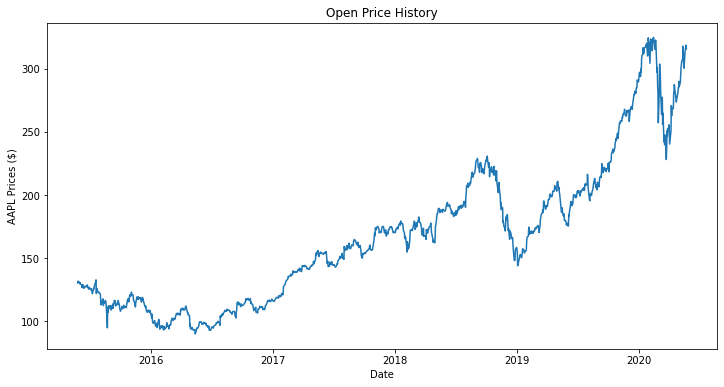

In [8]:
plt.figure(figsize = (12,6))
plt.plot(dataset["open"])
plt.title('Open Price History')
plt.xlabel("Date")
plt.ylabel("AAPL Prices ($)")
plt.show()

In [9]:
train_data = dataset.to_numpy()
train_data

array([[130.34],
       [131.86],
       [131.23],
       ...,
       [316.68],
       [318.66],
       [315.77]])

In [10]:
dataset_train = np.array(train_data[:int(train_data.shape[0]*0.7)]) 
dataset_test = np.array(train_data[int(train_data.shape[0]*0.7):])

print("The shape of the training set is: ", dataset_train.shape)
print("The shape of the testing set is: ", dataset_test.shape)

The shape of the training set is:  (880, 1)
The shape of the testing set is:  (378, 1)


In [11]:
scalar = MinMaxScaler(feature_range = (0,1))
train_data = scalar.fit_transform(train_data)
train_data.shape

(1258, 1)

In [12]:
x_train = train_data[0:1257]
y_train = train_data[1:1258]

x_train = np.reshape(x_train, (1257,1,1))
x_train.shape

(1257, 1, 1)

In [13]:
model = Sequential()
model.add(LSTM(units = 96, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 96, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 96, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 96))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 96)             37632     
                                                                 
 dropout (Dropout)           (None, 1, 96)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 96)             74112     
                                                                 
 dropout_1 (Dropout)         (None, 1, 96)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 96)             74112     
                                                                 
 dropout_2 (Dropout)         (None, 1, 96)             0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                7

In [14]:
model.compile(optimizer = 'adam', loss = "mean_squared_error")

In [15]:
modelo = model.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
40/40 [==============================] - 16s 12ms/step - loss: 0.0960
Epoch 2/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0208
Epoch 3/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0030
Epoch 4/100
40/40 [==============================] - 1s 13ms/step - loss: 0.0024
Epoch 5/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0024
Epoch 6/100
40/40 [==============================] - 1s 13ms/step - loss: 0.0020
Epoch 7/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0015
Epoch 8/100
40/40 [==============================] - 1s 15ms/step - loss: 0.0015
Epoch 9/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0014
Epoch 10/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0013
Epoch 11/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0015
Epoch 12/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0014
Epoch 13/100
40/40 [====

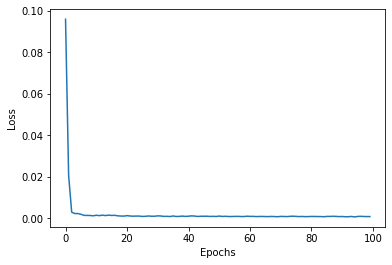

In [16]:
plt.plot(modelo.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [17]:
print(dataset_test)
print(dataset_test.shape)

[[178.37  ]
 [179.73  ]
 [174.94  ]
 [174.24  ]
 [171.51  ]
 [176.73  ]
 [182.66  ]
 [180.29  ]
 [184.46  ]
 [180.95  ]
 [171.76  ]
 [173.49  ]
 [165.    ]
 [171.66  ]
 [170.4   ]
 [170.49  ]
 [169.    ]
 [165.45  ]
 [165.38  ]
 [166.    ]
 [160.4   ]
 [156.86  ]
 [148.15  ]
 [148.3   ]
 [155.84  ]
 [157.5   ]
 [158.53  ]
 [154.89  ]
 [143.98  ]
 [144.53  ]
 [148.7   ]
 [149.56  ]
 [151.29  ]
 [152.5   ]
 [152.88  ]
 [150.85  ]
 [150.27  ]
 [153.08  ]
 [154.2   ]
 [157.5   ]
 [156.41  ]
 [154.15  ]
 [154.11  ]
 [155.48  ]
 [155.79  ]
 [156.25  ]
 [163.25  ]
 [166.11  ]
 [166.96  ]
 [167.41  ]
 [172.86  ]
 [174.65  ]
 [172.4   ]
 [168.99  ]
 [171.05  ]
 [170.1   ]
 [171.39  ]
 [169.71  ]
 [171.25  ]
 [169.71  ]
 [171.19  ]
 [171.8   ]
 [171.58  ]
 [174.16  ]
 [173.71  ]
 [173.21  ]
 [174.32  ]
 [174.28  ]
 [175.69  ]
 [175.94  ]
 [174.67  ]
 [173.87  ]
 [170.32  ]
 [175.49  ]
 [180.    ]
 [182.25  ]
 [183.9   ]
 [184.85  ]
 [185.8   ]
 [188.35  ]
 [186.23  ]
 [190.02  ]
 [195.34  ]
 [19

In [18]:
inputs = np.reshape(scalar.transform(dataset_test), (378,1,1))
stock_prediction = scalar.inverse_transform(model.predict(inputs))
print(stock_prediction)
print(stock_prediction.shape)

12/12 [==============================] - 3s 6ms/step
[[177.81285]
 [179.26031]
 [174.17363]
 [173.43301]
 [170.55174]
 [176.07076]
 [182.38672]
 [179.85701]
 [184.31248]
 [180.56079]
 [170.81511]
 [172.64032]
 [163.73018]
 [170.70975]
 [169.38359]
 [169.47823]
 [167.9131 ]
 [164.19936]
 [164.12634]
 [164.77328]
 [158.95557]
 [155.30894]
 [146.44753]
 [146.59872]
 [154.26291]
 [155.96635]
 [157.02614]
 [153.29059]
 [142.26447]
 [142.81389]
 [147.0022 ]
 [147.87088]
 [149.62328]
 [150.8528 ]
 [151.23958]
 [149.17694]
 [148.58926]
 [151.44328]
 [152.58554]
 [155.96635]
 [154.8472 ]
 [152.5345 ]
 [152.49367]
 [153.89423]
 [154.21169]
 [154.68312]
 [161.90909]
 [164.88814]
 [165.77634]
 [166.24707]
 [171.97511]
 [173.86671]
 [171.48978]
 [167.90263]
 [170.0674 ]
 [169.06822]
 [170.42535]
 [168.65845]
 [170.27795]
 [168.65845]
 [170.21478]
 [170.85725]
 [170.62547]
 [173.34842]
 [172.87274]
 [172.34459]
 [173.51762]
 [173.47531]
 [174.96796]
 [175.2329 ]
 [173.88788]
 [173.04184]
 [169.29947

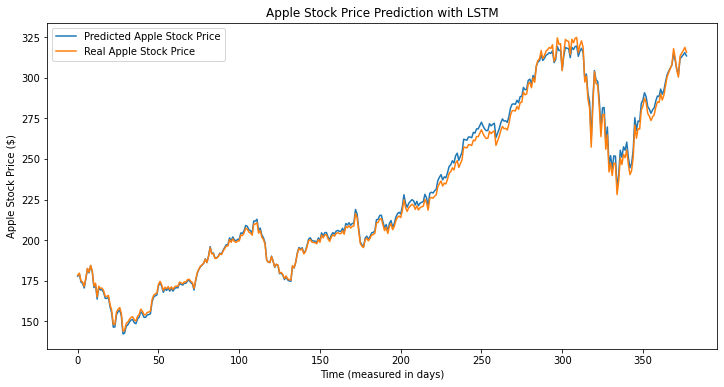

In [19]:
plt.figure(figsize = (12,6))
plt.plot(stock_prediction, label = "Predicted Apple Stock Price", linewidth = 1.5)
plt.plot(dataset_test, label = "Real Apple Stock Price", linewidth = 1.5)
plt.title("Apple Stock Price Prediction with LSTM")
plt.xlabel("Time (measured in days)")
plt.ylabel("Apple Stock Price ($)")
plt.legend()
plt.show()

In [20]:
import sklearn.metrics
test_mae_nn = sklearn.metrics.mean_absolute_error(dataset_test, stock_prediction.squeeze())
print("The Mean Absolute Error of the Test Data is", test_mae_nn)

The Mean Absolute Error of the Test Data is 2.2376221578285183
